# Trying to get it work for centralized and decentralized models

In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

from importlib import reload
import utils
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)

<module 'utils.train_test_methods' from '/Users/zz/Documents/GT 20F/7000/GNN_experiments/utils/train_test_methods.py'>

In [4]:
U_VELOCITY = 1
U_ACCELERATION = 2
O_VELOCITY = 1
O_ACCELERATION = 2
O_ACTION = 1
O_NO_ACTION = 0
DIST_REWARD = 0
TIME_REWARD = 1
ACT_REWARD = 2
ALL_REWARD = 3

# Use the purple-pink pair (LA-uVel-oVel & RA-uVel-oVel) as example
input_type = U_VELOCITY
observe_type = O_VELOCITY
observe_action = O_ACTION
reward_mode=ALL_REWARD

N = 10
env = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, 
              observe_action=observe_action, reward_mode=reward_mode).unwrapped


In [ ]:
# Load pre-trained models
agent5 = LearnerAgent(device, N, env.no, env.na, hidden)
agent7 = RewardAgent(device, N, env.no, env.na, hidden)
agent5.load_model('models/LearnerAgent_test3_LA-uVel-oVel')
agent7.load_model('models/RewardAgent_test3_RA-uVel-oVel')

## We first try training a centralized agent, for sanity check

In [7]:
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *


In [8]:
na = env.na
ns = env.nf
hidden = 32

num_episode=250
transfer_num_episode=101
test_interval=25#50
num_test=25
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50

if input_type == U_ACCELERATION:
    action_space = [-env.a_max, env.a_max]
else:
    action_space = [-env.v_max, env.v_max]


In [9]:
# Train the base network (10 agents) for sanity check
N = 10
seed=202020

LA10_ms = LearnerAgent(device, N, env.no, env.na, hidden, centralized=True, action_range=action_space)
RA10_ms = RewardAgent(device, N, env.nf-env.np, env.na, hidden, centralized=True)
RA10_ms_dc = RewardAgent(device, N, env.nf-env.np, env.na, hidden, centralized=True)

LA10_hist = train(LA10_ms, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA10_hist = train(RA10_ms, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA10_hist_dc = train(RA10_ms_dc, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES)

I didn't learn anything!
Test result at episode  0 : 
Test result at episode  25 : 
Test result at episode  50 : 
Test result at episode  75 : 
Test result at episode  100 : 
Test result at episode  125 : 
Test result at episode  150 : 
Test result at episode  175 : 
Test result at episode  200 : 
Test result at episode  225 : 
Test result at episode  0 : 
Test result at episode  25 : 
Test result at episode  50 : 
Test result at episode  75 : 
Test result at episode  100 : 
Test result at episode  125 : 
Test result at episode  150 : 
Test result at episode  175 : 
Test result at episode  200 : 
Test result at episode  225 : 


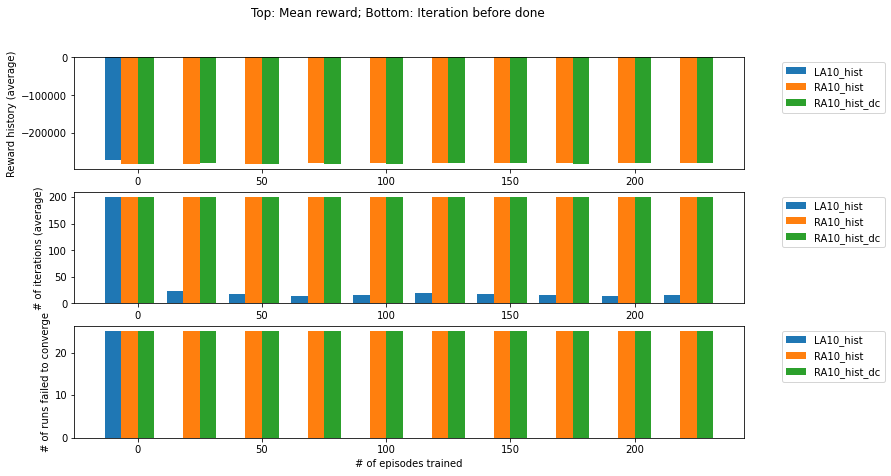

In [10]:
# Test the base network to make sure they work well, and have worked well
plot_reward_hist([LA10_hist, RA10_hist, RA10_hist_dc], test_interval, 
                 ['LA10_hist', 'RA10_hist', 'RA10_hist_dc'], 
                 log=False, num_iteration=num_iteration)

I didn't learn anything!
Test result at episode  0 : 
Test result at episode  25 : 
Test result at episode  50 : 
Test result at episode  75 : 
Test result at episode  100 : 
Test result at episode  125 : 
Test result at episode  150 : 
Test result at episode  175 : 
Test result at episode  200 : 
Test result at episode  225 : 
Test result at episode  0 : 
Test result at episode  25 : 
Test result at episode  50 : 
Test result at episode  75 : 
Test result at episode  100 : 
Test result at episode  125 : 
Test result at episode  150 : 
Test result at episode  175 : 
Test result at episode  200 : 
Test result at episode  225 : 


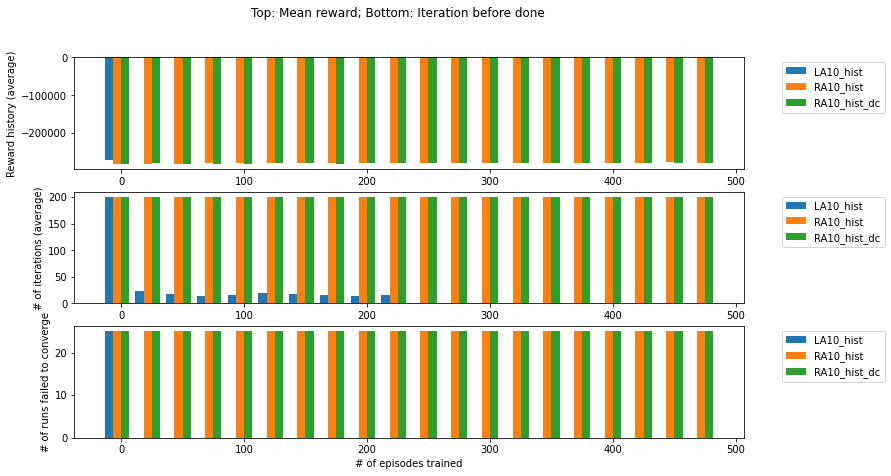

In [11]:
# Additional training
RA10_hist += train(RA10_ms, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA10_hist_dc += train(RA10_ms_dc, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES)
plot_reward_hist([LA10_hist, RA10_hist, RA10_hist_dc], test_interval, 
                 ['LA10_hist', 'RA10_hist', 'RA10_hist_dc'], 
                 log=False, num_iteration=num_iteration)

In [ ]:
# If all goes well, save the weights
LA10_ms.save_model('LA10_master_agent_fail')
RA10_ms.save_model('RA10_master_agent_fail')
RA10_ms_dc.save_model('RA10_master_agent_discount_fail')

In [ ]:
# Train the base network (32 agents because hidden layer is only that big)
N = 32
seed=32323

env_ms = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, 
              observe_action=observe_action, reward_mode=reward_mode).unwrapped
LA32_ms = LearnerAgent(device, N, env_ms.no, env_ms.na, hidden, centralized=True, action_range=action_space)
RA32_ms = RewardAgent(device, N, env_ms.nf-env_ms.np, env_ms.na, hidden, centralized=True)
RA32_ms_dc = RewardAgent(device, N, env_ms.nf-env_ms.np, env_ms.na, hidden, centralized=True)

LA32_hist = train(LA32_ms, env_ms, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA32_hist = train(RA32_ms, env_ms, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA32_hist_dc = train(RA32_ms_dc, env_ms, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES)

Test result at episode  0 : 
Test result at episode  25 : 
Test result at episode  50 : 
Test result at episode  75 : 
Test result at episode  100 : 
Test result at episode  125 : 
Test result at episode  150 : 
Test result at episode  175 : 
Test result at episode  200 : 
Test result at episode  225 : 
I didn't learn anything!
Test result at episode  0 : 
Test result at episode  25 : 
Test result at episode  50 : 
Test result at episode  75 : 
Test result at episode  100 : 
Test result at episode  125 : 
Test result at episode  150 : 
Test result at episode  175 : 


In [ ]:
# RA32_hist += train(RA32_ms, env_ms, num_episode, test_interval, num_test, 
#                    num_iteration, BATCH_SIZE*4, num_sample, action_space, debug, 
#                    seed=seed, reward_mode=FUTURE_REWARD_NO)
RA32_hist_dc += train(RA32_ms_dc, env_ms, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE*4, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES)

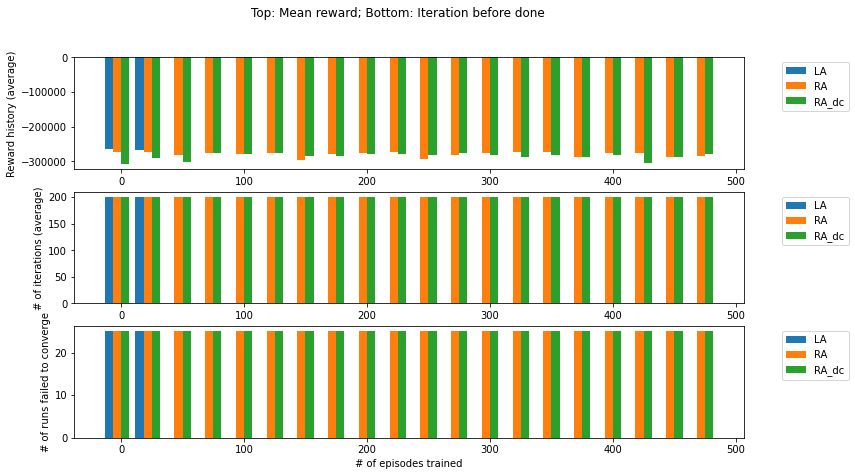

In [12]:
# Test the base network to make sure they work well, and have worked well
plot_reward_hist([LA32_hist, RA32_hist, RA32_hist_dc], test_interval, 
                 ['LA', 'RA', 'RA_dc'], 
                 log=False, num_iteration=num_iteration)

In [43]:
env_ms.nf

7

In [ ]:
# If all goes well, save the weights
LA32_ms.save_model('LA32_master_agent')
RA32_ms.save_model('RA32_master_agent')
RA32_ms_dc.save_model('RA32_master_agent_discount')

### Test out different training setups and compare
using the new reward

In [ ]:
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

num_episode=250
test_interval=25
num_test=25
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50
transfer_num_episode=200
seed=2333333

# Bulid environments with different number of agents
env_list = []
env5_list = []
N_list = [5]#, 10, 20, 32]#, 50, 64]
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_NO_ACTION
        ).unwrapped
    )
    env5_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION
        ).unwrapped
    )

# Initialize 4 different groups of agents
# Type 1: Learn from scratch using cumulative reward 
RA_cumu_list = []
# Type 2: Learn from scratch using non-cumulative reward 
RA_inst_list = []
# Type 3: Learn from scratch using normalized cumulative reward 
RA_norm_list = []
# Type 4: Transfer learning to the new environment from models saved using old reward function
RA_trsf_list = []
RApath = 'models/RewardAgent_RA32_master_agent'
prevN = 32
# Type 4, v2: Trans train using cumulative reward
RA_trfc_list = []
# Type 5: Learn while observing others' past actions
RA_obac_list = []

for i,N_ in enumerate(N_list):
    RA_cumu_list.append(
        RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden, learning_rate=0.1)
    )
    RA_inst_list.append(
        RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden, learning_rate=0.1)
    )
    RA_norm_list.append(
        RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden, learning_rate=0.1)
    )
#     RA_trsf_list.append(
#         RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden, learning_rate=0.1, prevN=prevN, load_path=RApath)
#     )
#     RA_trfc_list.append(
#         RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden, learning_rate=0.1, prevN=prevN, load_path=RApath)
#     )
#     RA_obac_list.append(
#         RewardAgent(device, N_, env5_list[i].nf, env_list[i].na, hidden, learning_rate=0.1)
#     )

In [ ]:
# Train those agents one by one, I guess
RA_cumu_hists = []
RA_inst_hists = []
RA_norm_hists = []
RA_trsf_hists = []
RA_obac_hists = []
RA_cumu_lossess = [[] for i in N_list]
RA_inst_lossess = [[] for i in N_list]
RA_norm_lossess = [[] for i in N_list]
RA_trsf_lossess = [[] for i in N_list]
RA_obac_lossess = [[] for i in N_list]
RA_trfc_lossess = [[] for i in N_list]
RA_cumu_lr_hist = [[] for i in N_list]
RA_inst_lr_hist = [[] for i in N_list]
RA_norm_lr_hist = [[] for i in N_list]
RA_trsf_lr_hist = [[] for i in N_list]
RA_obac_lr_hist = [[] for i in N_list]
RA_trfc_lr_hist = [[] for i in N_list]
for i,N_ in enumerate(N_list):
    RA_cumu_hists.append(
        train(RA_cumu_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_YES, loss_history=RA_cumu_lossess[i], lr_history=RA_cumu_lr_hist[i]
        )
    )
    RA_inst_hists.append(
        train(RA_inst_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_NO, loss_history=RA_inst_lossess[i], lr_history=RA_inst_lr_hist[i]
        )
    )
    RA_norm_hists.append(
        train(RA_norm_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=RA_norm_lossess[i], lr_history=RA_norm_lr_hist[i]
        )
    )
#     RA_trsf_hists.append(
#         train(RA_trsf_list[i], env_list[i], 
#               transfer_num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
#               seed=seed, reward_mode=FUTURE_REWARD_NO, loss_history=RA_trsf_lossess[i], lr_history=RA_trsf_lr_hist[i]
#         )
#     )
#     RA_obac_hists.append(
#         train(RA_obac_list[i], env5_list[i], 
#               num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
#               seed=seed, reward_mode=FUTURE_REWARD_YES, loss_history=RA_obac_lossess[i], lr_history=RA_obac_lr_hist[i]
#         )
#     )
#     RA_trfc_hists.append(
#         train(RA_trfc_list[i], env_list[i], 
#               transfer_num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
#               seed=seed, reward_mode=FUTURE_REWARD_YES, loss_history=RA_trfc_lossess[i], lr_history=RA_trfc_lr_hist[i]
#         )
#     )
    print("Finished training env with {0} agents for RA".format(N_))

In [ ]:
num_episode=250
for i,N_ in enumerate(N_list):
    RA_cumu_hists[i]+=train(RA_cumu_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_YES, loss_history=RA_cumu_lossess[i]
        )
    
    RA_inst_hists[i]+=train(RA_inst_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_NO, loss_history=RA_inst_lossess[i]
        )
    
    RA_norm_hists[i]+=train(RA_norm_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=RA_norm_lossess[i]
        )
    

In [ ]:
RA_trfc_hists = []
for i,N_ in enumerate(N_list):
    RA_trfc_hists.append(
        train(RA_trfc_list[i], env_list[i], 
              transfer_num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_YES
        )
    )

In [ ]:
for i,N_ in enumerate(N_list):
    RA_cumu_list[i].save_model('rewardV2_N{0}_cumu_test1'.format(N_))
    RA_inst_list[i].save_model('rewardV2_N{0}_inst_test1'.format(N_))
    RA_norm_list[i].save_model('rewardV2_N{0}_norm_test1'.format(N_))
    RA_trsf_list[i].save_model('rewardV2_N{0}_trsf_test1'.format(N_))
    RA_obac_list[i].save_model('rewardV2_N{0}_obac_test1'.format(N_))
    RA_trfc_list[i].save_model('rewardV2_N{0}_trfc_test1'.format(N_))

In [ ]:
# Plot per group
comb_hists = [RA_cumu_hists,RA_inst_hists,RA_norm_hists,RA_trsf_hists,RA_trfc_hists,RA_obac_hists]
comb_names = [['RA_{1}_N{0}'.format(N_,name) for N_ in N_list] for name in [
    'cum_reward','no_cum_reward','cum_norm_reward','tf_no_cum','tf_cum_reward','observe_action_cum']]
i = 5
plot_reward_hist(comb_hists[i], test_interval, 
                 comb_names[i], 
                 log=False, num_iteration=num_iteration, N_list=[1 for N_ in N_list])

In [ ]:
# Plot per # of agent
cumb_hists = [[RA_cumu_hists[i],RA_inst_hists[i],RA_norm_hists[i],
               RA_trsf_hists[i],RA_trfc_hists[i],RA_obac_hists[i]] for i in range(len(N_list))]
cumb_names = [['RA_{1}_N{0}'.format(N_,name) for name in [
    'cum_reward','no_cum_reward','cum_norm_reward','tf_no_cum','tf_cum_reward','observe_action_cum']] for N_ in N_list]
j = 3
plot_reward_hist(cumb_hists[j], test_interval, 
                 cumb_names[j], 
                 log=False, num_iteration=num_iteration, N_list=[N_list[j]]*6)

In [ ]:
# Plot per # of agent
cumb_hists = [[RA_cumu_hists[i],RA_inst_hists[i],RA_norm_hists[i]] for i in range(len(N_list))]
cumb_names = [['RA_{1}_N{0}'.format(N_,name) for name in [
    'cum_reward','no_cum_reward','cum_norm_reward','tf_no_cum','tf_cum_reward','observe_action_cum']] for N_ in N_list]
j = 0
plot_reward_hist(cumb_hists[j], test_interval, 
                 cumb_names[j], 
                 log=False, num_iteration=num_iteration, N_list=[N_list[j]]*6)

In [ ]:
reload(utils.plotting)
from utils.plotting import *
# Plot loss per # of agent
# cumb_hists = [[RA_cumu_lossess[i],RA_inst_lossess[i],RA_norm_lossess[i],
#                RA_trsf_lossess[i],RA_trfc_lossess[i],RA_obac_lossess[i]] for i in range(len(N_list))]
cumb_hists = [[RA_cumu_lossess[i][50:],RA_inst_lossess[i][50:],RA_norm_lossess[i][50:]] for i in range(len(N_list))]
# cumb_names = [['RA_{1}_N{0}'.format(N_,name) for name in [
#     'cum_reward','no_cum_reward','cum_norm_reward','tf_no_cum','tf_cum_reward','observe_action_cum']] for N_ in N_list]
cumb_names = [['RA_{1}_N{0}'.format(N_,name) for name in [
    'cum_reward','no_cum_reward','cum_norm_reward']] for N_ in N_list]
j = 0
plot_loss_hist(hists=cumb_hists[j], hist_names=cumb_names[j], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION)

In [ ]:
reload(utils.plotting)
from utils.plotting import *
# Plot learning rate per # of agent
cumb_hists = [[RA_cumu_lr_hist[i],RA_inst_lr_hist[i],RA_norm_lr_hist[i]] for i in range(len(N_list))]
cumb_names = [['RA_{1}_N{0}'.format(N_,name) for name in [
    'cum_reward','no_cum_reward','cum_norm_reward']] for N_ in N_list]
j = 0
plot_lr(hists=cumb_hists[j], hist_names=cumb_names[j], log=True)

### How about using CNN?

In [ ]:
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

num_episode=500
test_interval=25
num_test=25
num_iteration=200
BATCH_SIZE=256
debug=False
num_sample=50
seed=2333333
hidden=8

NCN_list = [5,10] 
envCNN_list = []
for N_ in NCN_list:
    envCNN_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION
        ).unwrapped
    )
LA_CNN_list = []
RA_CNN_list = []
for i,N_ in enumerate(NCN_list):
    LA_CNN_list.append(
        LearnerCNNAgent(device, N_, ns=envCNN_list[i].nf, na=env_list[i].na, hidden=hidden, n_hid=2, in_features=1)
    )
    RA_CNN_list.append(
        RewardCNNAgent(device, N_, ns=envCNN_list[i].nf, na=env_list[i].na, hidden=hidden, n_hid=2, in_features=1)
    )
LA_CNN_hists = []
RA_CNN_hists = []
for i,N_ in enumerate(NCN_list):
    LA_CNN_hists.append(
        train(LA_CNN_list[i], envCNN_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
                             seed=seed, reward_mode=FUTURE_REWARD_YES, update_mode=UPDATE_PER_EPISODE)
    )
    RA_CNN_hists.append(
        train(RA_CNN_list[i], envCNN_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
                             seed=seed, reward_mode=FUTURE_REWARD_YES, update_mode=UPDATE_PER_EPISODE)
    )
    print("Finished training env with {0} agents for CNN".format(N_))

In [ ]:
# Keep training those lazy gradients
num_episode=2600
test_interval=20
num_test=25
num_iteration=200
BATCH_SIZE=256
debug=False
num_sample=50
seed=2333333
hidden=8

for i,N_ in enumerate(NCN_list):
    LA_CNN_hists[i] += train(LA_CNN_list[i], envCNN_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
                             seed=seed, reward_mode=FUTURE_REWARD_YES)
    RA_CNN_hists[i] += train(RA_CNN_list[i], envCNN_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
                             seed=seed, reward_mode=FUTURE_REWARD_YES)
    print("Finished training env with {0} agents for CNN".format(N_))

In [ ]:
# Plot results
plot_reward_hist(LA_CNN_hists, test_interval, ['LA_CNN_N{0}'.format(N_) for N_ in NCN_list], 
                 log=False, num_iteration=num_iteration, N_list=[1 for N_ in NCN_list])

In [ ]:
plot_reward_hist(RA_CNN_hists, test_interval, ['RA_CNN_N{0}'.format(N_) for N_ in NCN_list], 
                 log=False, num_iteration=num_iteration, N_list=[1 for N_ in NCN_list])

In [ ]:
LA_CNN_list[0].save_model("LA_CNN_test1_3000epi_N5")
LA_CNN_list[1].save_model("LA_CNN_test1_3000epi_N10")
RA_CNN_list[0].save_model("RA_CNN_test1_3000epi_N5")
RA_CNN_list[1].save_model("LA_CNN_test1_3000epi_N10")

In [ ]:
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

# Additional training and testing and probing
num_episode=1#200
test_interval=20
num_test=1#25
num_iteration=200
BATCH_SIZE=32
debug=False
num_sample=50
seed=2333333
hidden=8

i = 0
N_ = 5
LCtest = LearnerCNNAgent(device, N_, ns=envCNN_list[i].nf, na=env_list[i].na, hidden=hidden, n_hid=2, in_features=1)
RCtest = RewardCNNAgent(device, N_, ns=envCNN_list[i].nf, na=env_list[i].na, hidden=hidden, n_hid=2, in_features=1)

LCtesth = train(LCtest, envCNN_list[i], 
          num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
RCtesth = train(RCtest, envCNN_list[i], 
          num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
print("Finished training env with {0} agents for CNN".format(N_))

### How about trying ResNet or similar structure?

In [ ]:
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

num_episode=50
test_interval=5
num_test=10#25
num_iteration=50#200
BATCH_SIZE=64
debug=False
num_sample=50
seed=2333333

NCN_list = [5] 
envCNN_list = []
for N_ in NCN_list:
    envCNN_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION
        ).unwrapped
    )
RA_RN_list = []
for i,N_ in enumerate(NCN_list):
    RA_RN_list.append(
        RewardRNAgent(device, N_, ns=envCNN_list[i].nf, na=env_list[i].na, n_hid=2, in_features=1)
    )
RA_RN_hists = []
RA_RN_lossess=[]
for i,N_ in enumerate(NCN_list):
    RA_RN_hists.append(
        train(RA_RN_list[i], envCNN_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
                             seed=seed, reward_mode=FUTURE_REWARD_YES, update_mode=UPDATE_PER_EPISODE,
                             loss_history=RA_RN_lossess)
    )
    print("Finished training env with {0} agents for RN".format(N_))

In [ ]:
# Plot per # of agent
plot_reward_hist(RA_RN_hists, test_interval, ['RA_ResNet_N5'], 
                 log=False, num_iteration=num_iteration, N_list=NCN_list)

In [ ]:
reload(utils.plotting)
from utils.plotting import *
# Plot loss per # of agent
plot_loss_hist(hists=[RA_RN_lossess], hist_names=['RA_ResNet_N5'], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION)

## Try out Actor-Critic

In [27]:
# Test out Actor-Critic methods. Note that tuning parameters might be required.
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=250#500
test_interval=5#0
num_test=10#50
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50
seed=22222

# N_list = [5,20,50,100] # 250 would take too long
N_list = [5,10,20]
env_list = []
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD
        ).unwrapped
    )

AC2_list = []
for i,N_ in enumerate(N_list[:4]):
    AC2_list.append(
        AC2Agent(device, N_, env_list[i].nf, env_list[i].na, hidden, 
                 learning_rateA=0.01, learning_rateC=0.02)
    )
# AC2_list.append(
#     AC2Agent(device, 10, env.no, env.na, hidden)
# )

AC2_hist = []
AC2_loss = []
for i,N_ in enumerate(N_list[:4]):
    AC2_loss.append([])
    AC2_hist.append(
        train(AC2_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
              update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC2_loss[i])
    )
    print("Finished training env with {0} agents for AC".format(N_))
# AC2_hist.append(
#     train(AC2_list[-1], env, 
#           num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
#     )

AC2_test_hist = []
for i,N_ in enumerate(N_list[:4]):
    AC2_test_hist.append(
        plot_test(AC2_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))
# AC2_test_hist.append(
#     plot_test(AC2_list[-1], env, fnames=['']*num_test,
#         num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
# )

Test result at episode  0 : 
Test result at episode  5 : 
Test result at episode  10 : 
Test result at episode  15 : 
Test result at episode  20 : 
Test result at episode  25 : 
Test result at episode  30 : 
Test result at episode  35 : 
Test result at episode  40 : 
Test result at episode  45 : 
Test result at episode  50 : 
Test result at episode  55 : 
Test result at episode  60 : 
Test result at episode  65 : 
Test result at episode  70 : 
Test result at episode  75 : 
Test result at episode  80 : 
Test result at episode  85 : 
Test result at episode  90 : 
Test result at episode  95 : 
Test result at episode  100 : 
Test result at episode  105 : 
Test result at episode  110 : 
Test result at episode  115 : 
Test result at episode  120 : 
Test result at episode  125 : 
Test result at episode  130 : 
Test result at episode  135 : 
Test result at episode  140 : 
Test result at episode  145 : 
Test result at episode  150 : 
Test result at episode  155 : 
Test result at episode  160 : 

In [ ]:
# additional testing
num_episode=1500
test_interval=5#0
num_test=10#50
num_iteration=200
env_list = []
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD
        ).unwrapped
    )
    
for i,N_ in enumerate(N_list[:4]):
#     AC2_list[i].optimizerA.learning_rate = 0.05
#     AC2_list[i].optimizerC.learning_rate = 0.08
    AC2_hist[i] += train(AC2_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
              update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC2_loss[i])
    print("Finished training env with {0} agents for AC".format(N_))

for i,N_ in enumerate(N_list[:4]):
    AC2_test_hist[i] += plot_test(AC2_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
    print("Finished testnig env with {0} agents for AC".format(N_))

In [ ]:
reload(utils.plotting)
from utils.plotting import *
skip = 1
plot_reward_hist([h[::skip] for h in AC2_hist], test_interval*skip, 
                 ['AC2_N{0}'.format(N_) for N_ in N_list[:4]], 
                 log=False, num_iteration=num_iteration, N_list=([1 for N in N_list[:4]]), bar=False)

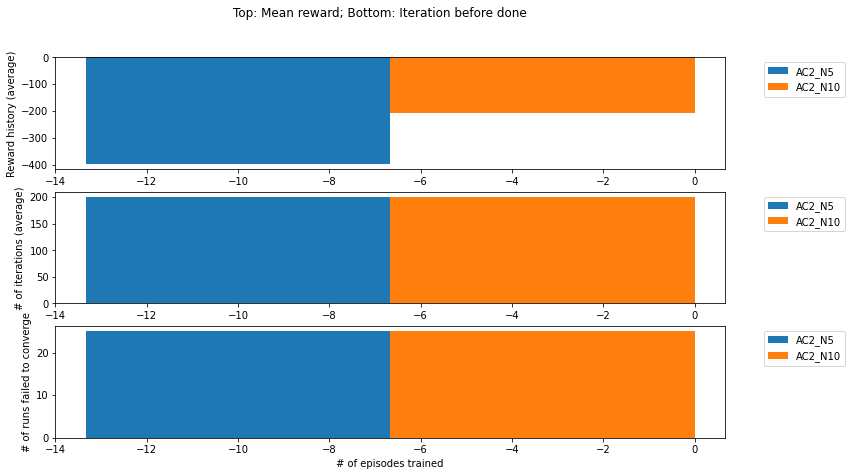

In [25]:
plot_reward_hist([[l] for l in AC2_test_hist], test_interval, 
                 ['AC2_N{0}'.format(N_) for N_ in N_list]+['AC2_N10'], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list]+[10])*2)

In [ ]:
# Plot loss per # of agent
skip=1
plot_loss_hist(hists=[h[::skip] for h in AC2_loss], hist_names=['AC2_N{0}'.format(N_) for N_ in N_list[:4]], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)

In [85]:
AC2_list[0].save_model("AC2_onlydistreward_normalized_N5")
AC2_list[1].save_model("AC2_onlydistreward_normalized_N10")
AC2_list[2].save_model("AC2_onlydistreward_normalized_N20")

Saving model to models/AC2Agent_AC2_onlydistreward_normalized_N5
Saving model to models/AC2Agent_AC2_onlydistreward_normalized_N10
Saving model to models/AC2Agent_AC2_onlydistreward_normalized_N20


In [ ]:
num_episode=500
test_interval=10#0
num_test=10#50
# N_list = [5]
env_list_allreward = []
N_list = [5,10,20]
for N_ in N_list:
    env_list_allreward.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=ALL_REWARD
        ).unwrapped
    )

AC2_list_allreward = []
for i,N_ in enumerate(N_list[:4]):
    AC2_list_allreward.append(
        AC2Agent(device, N_, env_list_allreward[i].nf, env_list_allreward[i].na, hidden, 
                 learning_rateA=0.01, learning_rateC=0.02)
    )

AC2_hist_allreward = []
AC2_loss_allreward = []
for i,N_ in enumerate(N_list[:4]):
    AC2_loss_allreward.append([])
    AC2_hist_allreward.append(
        train(AC2_list_allreward[i], env_list_allreward[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
              update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC2_loss_allreward[i])
    )
    print("Finished training env with {0} agents for AC".format(N_))

AC2_test_hist_allreward = []
for i,N_ in enumerate(N_list[:4]):
    AC2_test_hist_allreward.append(
        plot_test(AC2_list_allreward[i], env_list_allreward[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))

In [ ]:
plot_reward_hist(AC2_hist_allreward, test_interval, 
                 ['AC2_N{0}'.format(N_) for N_ in N_list[:4]], 
                 log=False, num_iteration=num_iteration, N_list=([1 for N in N_list[:4]]), bar=False)

In [ ]:
# Plot loss
plot_loss_hist(hists=[h[5::skip] for h in AC2_loss_allreward], hist_names=['AC2_N{0}'.format(N_) for N_ in N_list[:4]], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)

In [48]:
AC2_list_allreward[0].save_model("AC2_allreward_normalized_N5")
AC2_list_allreward[1].save_model("AC2_allreward_normalized_N10")
AC2_list_allreward[2].save_model("AC2_allreward_normalized_N20")

Saving model to models/AC2Agent_AC2_allreward_normalized_N5
Saving model to models/AC2Agent_AC2_allreward_normalized_N10
Saving model to models/AC2Agent_AC2_allreward_normalized_N20


In [109]:
reload(utils.plotting)
from utils.plotting import *
### Save their animations and see how they behave.
for i,N_ in enumerate(N_list):
    plot_test(AC2_list[i], env_list[i], fnames=['AC2_dist_reward_test{0}_N{1}'.format(j,N_) for j in range(3)],
        num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug)
    plot_test(AC2_list_allreward[i], env_list_allreward[i], fnames=['AC2_all_reward_test{0}_N{1}'.format(j,N_) for j in range(3)],
        num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug)

Finished episode  0  with  99 ;
cumulative reward =  -4731.4494197514305
Finished episode  1  with  99 ;
cumulative reward =  -5153.693242743248
Finished episode  2  with  99 ;
cumulative reward =  -5081.763071406728
Finished episode  0  with  99 ;
cumulative reward =  -11308.227650814204
Finished episode  1  with  99 ;
cumulative reward =  -10975.637769948189
Finished episode  2  with  99 ;
cumulative reward =  -10856.320880929872
Finished episode  0  with  99 ;
cumulative reward =  -26163.48483412173
Finished episode  1  with  99 ;
cumulative reward =  -25082.043036814284
Finished episode  2  with  99 ;
cumulative reward =  -25481.96634182731


<Figure size 432x288 with 0 Axes>

In [110]:
# Clear recorded histories
# AC2_hist_allreward = []
# AC2_loss_allreward = []

In [42]:
num_episode=250#500
test_interval=5#0
num_test=10#50
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50
seed=22222

# N_list = [5,20,50,100] # 250 would take too long
N_list = [5,10,20]
env_list = []
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD
        ).unwrapped
    )

AC3_list = []
for i,N_ in enumerate(N_list[:4]):
    AC3_list.append(
        AC3Agent(device, N_, env_list[i].nf, env_list[i].na, hidden, 
                 learning_rateA=0.01, learning_rateC=0.02)
    )

AC3_hist = []
AC3_loss = []
for i,N_ in enumerate(N_list[:4]):
    AC3_loss.append([])
    AC3_hist.append(
        train(AC3_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
              update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC3_loss[i])
    )
    print("Finished training env with {0} agents for AC".format(N_))

AC3_test_hist = []
for i,N_ in enumerate(N_list[:4]):
    AC3_test_hist.append(
        plot_test(AC3_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))

Test result at episode  0 : 
Test result at episode  5 : 
Test result at episode  10 : 
Test result at episode  15 : 
Test result at episode  20 : 
Test result at episode  25 : 
Test result at episode  30 : 
Test result at episode  35 : 
Test result at episode  40 : 
Test result at episode  45 : 
Test result at episode  50 : 
Test result at episode  55 : 
Test result at episode  60 : 
Test result at episode  65 : 
Test result at episode  70 : 
Test result at episode  75 : 
Test result at episode  80 : 
Test result at episode  85 : 
Test result at episode  90 : 
Test result at episode  95 : 
Test result at episode  100 : 
Test result at episode  105 : 
Test result at episode  110 : 
Test result at episode  115 : 
Test result at episode  120 : 
Test result at episode  125 : 
Test result at episode  130 : 
Test result at episode  135 : 
Test result at episode  140 : 
Test result at episode  145 : 
Test result at episode  150 : 
Test result at episode  155 : 
Test result at episode  160 : 

In [112]:
# Keep training
num_episode=1000
test_interval=5
num_test=10
num_iteration=200

# N_list = [5,20,50,100] # 250 would take too long
N_list = [5,10,20]
env_list = []
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD
        ).unwrapped
    )

for i,N_ in enumerate(N_list[:4]):
    AC3_list[i].optimizerA.learning_rate = 0.05
    AC3_list[i].optimizerC.learning_rate = 0.08
    AC3_hist[i] += train(AC3_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
              update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC3_loss[i])
    print("Finished training env with {0} agents for AC".format(N_))

for i,N_ in enumerate(N_list[:4]):
    AC3_test_hist[i] += plot_test(AC3_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
    print("Finished testnig env with {0} agents for AC".format(N_))

Test result at episode  0 : 
Test result at episode  5 : 
Test result at episode  10 : 
Test result at episode  15 : 
Test result at episode  20 : 
Test result at episode  25 : 
Test result at episode  30 : 
Test result at episode  35 : 
Test result at episode  40 : 
Test result at episode  45 : 
Test result at episode  50 : 
Test result at episode  55 : 
Test result at episode  60 : 
Test result at episode  65 : 
Test result at episode  70 : 
Test result at episode  75 : 
Test result at episode  80 : 
Test result at episode  85 : 
Test result at episode  90 : 
Test result at episode  95 : 
Test result at episode  100 : 
Test result at episode  105 : 
Test result at episode  110 : 
Test result at episode  115 : 
Test result at episode  120 : 
Test result at episode  125 : 
Test result at episode  130 : 
Test result at episode  135 : 
Test result at episode  140 : 
Test result at episode  145 : 
Test result at episode  150 : 
Test result at episode  155 : 
Test result at episode  160 : 

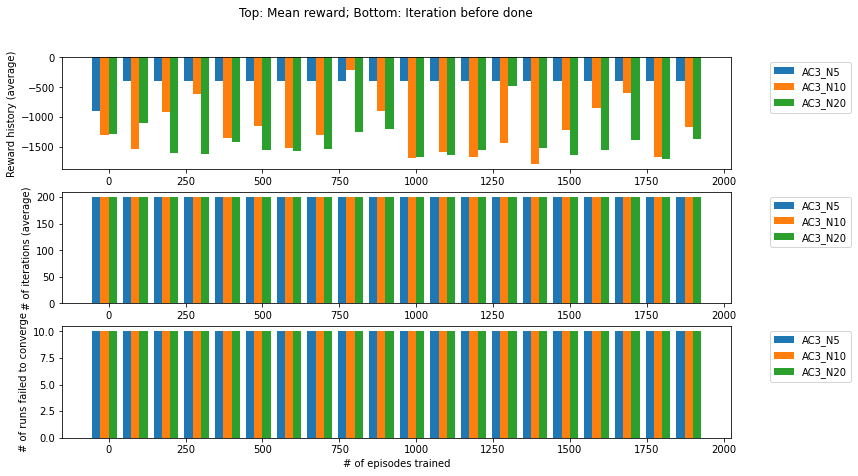

In [115]:
skip=20
plot_reward_hist([h[::skip] for h in AC3_hist], test_interval*skip, 
                 ['AC3_N{0}'.format(N_) for N_ in N_list[:4]], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list[:4]]), bar=True)

In [ ]:
# Plot loss per # of agent
skip=1
plot_loss_hist(hists=[h[::skip] for h in AC3_loss], hist_names=['AC3_N{0}'.format(N_) for N_ in N_list[:4]], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)

In [113]:
AC3_list[0].save_model("AC3_onlydistreward_normalized_N5")
AC3_list[1].save_model("AC3_onlydistreward_normalized_N10")
AC3_list[2].save_model("AC3_onlydistreward_normalized_N20")

Saving model to models/AC3Agent_AC3_onlydistreward_normalized_3000_N5
Saving model to models/AC3Agent_AC3_onlydistreward_normalized_3000_N10
Saving model to models/AC3Agent_AC3_onlydistreward_normalized_3000_N20


In [ ]:
num_episode=500
test_interval=10#0
num_test=10#50
env_list_allreward = []
N_list = [5,10,20]
for N_ in N_list:
    env_list_allreward.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=ALL_REWARD
        ).unwrapped
    )

AC3_list_allreward = []
for i,N_ in enumerate(N_list[:4]):
    AC3_list_allreward.append(
        AC2Agent(device, N_, env_list_allreward[i].nf, env_list_allreward[i].na, hidden, 
                 learning_rateA=0.01, learning_rateC=0.02)
    )

AC3_hist_allreward = []
AC3_loss_allreward = []
for i,N_ in enumerate(N_list[:4]):
    AC3_loss_allreward.append([])
    AC3_hist_allreward.append(
        train(AC3_list_allreward[i], env_list_allreward[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
              update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC3_loss_allreward[i])
    )
    print("Finished training env with {0} agents for AC".format(N_))

AC3_test_hist_allreward = []
for i,N_ in enumerate(N_list[:4]):
    AC3_test_hist_allreward.append(
        plot_test(AC3_list_allreward[i], env_list_allreward[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))

In [ ]:
skip = 1
plot_reward_hist([h[2::skip] for h in AC3_hist_allreward], test_interval*skip, 
                 ['AC3_N{0}'.format(N_) for N_ in N_list[:4]], 
                 log=False, num_iteration=num_iteration, N_list=([1 for N in N_list[:4]]), bar=False)

In [ ]:
# Plot loss
skip=1
plot_loss_hist(hists=[h[5::skip] for h in AC3_loss_allreward], hist_names=['AC3_N{0}'.format(N_) for N_ in N_list[:4]], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)

In [49]:
AC3_list_allreward[0].save_model("AC3_allreward_normalized_N5")
AC3_list_allreward[1].save_model("AC3_allreward_normalized_N10")
AC3_list_allreward[2].save_model("AC3_allreward_normalized_N20")

Saving model to models/AC2Agent_AC3_allreward_normalized_N5
Saving model to models/AC2Agent_AC3_allreward_normalized_N10
Saving model to models/AC2Agent_AC3_allreward_normalized_N20


In [117]:
reload(utils.plotting)
from utils.plotting import *
### Save their animations and see how they behave.
for i,N_ in enumerate(N_list):
    plot_test(AC3_list[i], env_list[i], fnames=['AC3_dist_reward_test{0}_N{1}'.format(j,N_) for j in range(3)],
        num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug)
#     plot_test(AC3_list_allreward[i], env_list_allreward[i], fnames=['AC3_all_reward_test{0}_N{1}'.format(j,N_) for j in range(3)],
#         num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug)

Finished episode  0  with  99 ;
cumulative reward =  -4878.524448529784
Finished episode  1  with  99 ;
cumulative reward =  -4878.9808283917355
Finished episode  2  with  99 ;
cumulative reward =  -4935.346769331861
Finished episode  0  with  99 ;
cumulative reward =  -38275.258413423464
Finished episode  1  with  99 ;
cumulative reward =  -40579.144749352716
Finished episode  2  with  99 ;
cumulative reward =  -45368.396375618795
Finished episode  0  with  99 ;
cumulative reward =  -124197.28412464196
Finished episode  1  with  99 ;
cumulative reward =  -159430.7937167494
Finished episode  2  with  99 ;
cumulative reward =  -119916.70460990266


<Figure size 432x288 with 0 Axes>

In [111]:
# Clear some histories
# AC3_hist_allreward = []
# AC3_loss_allreward = []

### DDPG

In [ ]:
reload(utils.agents)
from utils.agents import *

num_episode=500
test_interval=50
num_test=50
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50

# Do DDPG
DDPG_list = []
for i,N_ in enumerate(N_list):
    DDPG_list.append(
        DDPGAgent(device, N_, env_list[i].no, env_list[i].na, hidden)
    )
DDPG_list.append(
    DDPGAgent(device, 10, env.no, env.na, hidden)
)

DDPG_hist = []
for i,N_ in enumerate(N_list):
    DDPG_hist.append(
        train(DDPG_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for AC".format(N_))
DDPG_hist.append(
    train(DDPG_list[-1], env, 
          num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
)
    
DDPG_test_hist = []
for i,N_ in enumerate(N_list):
    DDPG_test_hist.append(
        plot_test(DDPG_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))
DDPG_test_hist.append(
    plot_test(DDPG_list[-1], env, fnames=['']*num_test,
        num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
)

In [ ]:

DDPG_test_hist = []
for i,N_ in enumerate(N_list):
    DDPG_test_hist.append(
        plot_test(DDPG_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))
DDPG_test_hist.append(
    plot_test(DDPG_list[-1], env, fnames=['']*num_test,
        num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
)

In [ ]:
plot_reward_hist(DDPG_hist, test_interval, 
                 ['DDPG_N{0}'.format(N_) for N_ in N_list]+['DDPG_N10'], 
                 log=False, num_iteration=num_iteration, N_list=([np.sqrt(N) for N in N_list]+[np.sqrt(10)])*2)

In [ ]:
plot_reward_hist([[l] for l in DDPG_test_hist], test_interval, 
                 ['DDPG_N{0}'.format(N_) for N_ in N_list]+['DDPG_N10'], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list]+[10])*2)

In [ ]:

def save_model(agent, suffix="", agent_path=None):
    if not os.path.exists('models/'):
        os.makedirs('models/')

    if len(suffix) <= 0:
        suffix = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    if agent_path is None:
        agent_path = "models/{}_{}".format(agent.name, suffix)
    print('Saving model to {}'.format(agent_path))
    torch.save(agent.netA.state_dict(), agent_path+"_A")
    torch.save(agent.netC.state_dict(), agent_path+"_C")
    
for i,N_ in enumerate(N_list+[10]):
    save_model(AC2_list[i],'AC2_test2_N{0}'.format(N_))
    
def save_model(agent, suffix="", agent_path=None):
    if not os.path.exists('models/'):
        os.makedirs('models/')

    if len(suffix) <= 0:
        suffix = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    if agent_path is None:
        agent_path = "models/{}_{}".format(agent.name, suffix)
    print('Saving model to {}'.format(agent_path))
    torch.save(agent.netA.state_dict(), agent_path+"_A")
    torch.save(agent.netC.state_dict(), agent_path+"_C")
    torch.save(agent.netAT.state_dict(), agent_path+"_AT")
    torch.save(agent.netCT.state_dict(), agent_path+"_CT")
    
for i,N_ in enumerate(N_list+[10]):
    save_model(DDPG_list[i],'DDPG_test2_N{0}'.format(N_))

### Play around with the gradient agent